### Research Text Classification using LSTM

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2070 with Max-Q Design (UUID: GPU-7bc2bbc8-06a1-cb8c-526b-b7fe3906990f)


In [26]:
# Start by using the 20k dataset
data_dir = "data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [45]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [221]:
def prep_df_from_txt(filename, directory):
    with open(directory+filename, "r") as file:
        lines = file.readlines()  
        master_list = []
        inner_list = []
        for line in lines:
            if line.strip() != "":
                inner_list.append(line)
            else:
                master_list.append(inner_list)
                inner_list = []
    
    samples = []       
    for inner_list in master_list:
        for num,line in enumerate(inner_list[1:]):
            collect = {}
            splits = line.split("\t")
            target = splits[0]
            text = splits[1].strip().lower()
            collect['target'] = target
            collect['text'] = text
            collect['line_number'] = num + 1 
            collect['total_lines'] = len(inner_list)-1
            samples.append(collect)
    sample_df = pd.DataFrame(samples)
    return sample_df

In [222]:
import pandas as pd
directory = 'data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
val_df = prep_df_from_txt('dev.txt',directory)
train_df = prep_df_from_txt('train.txt',directory)
test_df = prep_df_from_txt('test.txt',directory)

In [223]:

# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [225]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,1,12
1,METHODS,a total of @ patients with primary knee oa wer...,2,12
2,METHODS,outcome measures included pain reduction and i...,3,12
3,METHODS,pain was assessed using the visual analog pain...,4,12
4,METHODS,secondary outcome measures included the wester...,5,12


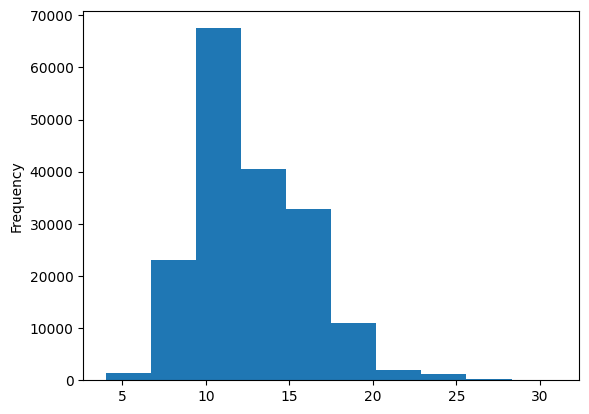

In [226]:

train_df.total_lines.plot.hist();

In [227]:

# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [228]:
train_df['target'].to_numpy()

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

In [185]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

train_labels_one_hot = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = ohe.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = ohe.fit_transform(val_df["target"].to_numpy().reshape(-1,1))

In [229]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

#### Baseline Model - Naive Bayes with TF-IDF

In [230]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Creating a Pipeline
model_0 = Pipeline([
    ('vectorizer',TfidfVectorizer()),
    ('classifier',MultinomialNB())
])

model_0.fit(X=train_sentences,y=train_labels_encoded)

# Evaluate baseline on validation dataset
format(model_0.score(X=val_sentences,
              y=val_labels_encoded),'.2%')

'72.18%'

### Model 1

In [260]:
import numpy as np
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
round(avg_sent_len,0)

26.0

95th Percentile lenght is  55


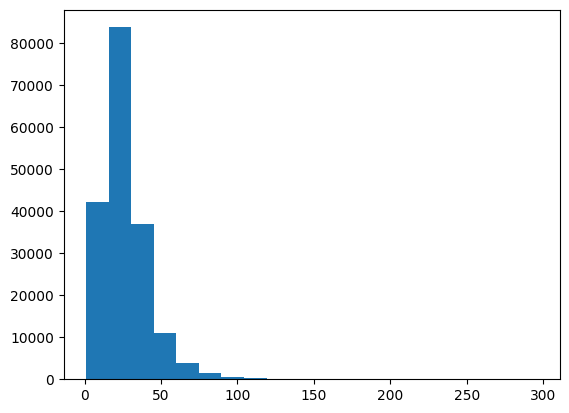

In [274]:

# What's the distribution look like?
import numpy as np
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);
len_95p = int(np.percentile(sent_lens,95))
print("95th Percentile lenght is ",len_95p)

In [252]:
train_df_words = train_df['text'].map(lambda x: x.split(" "))

In [253]:
train_word_list = []
for i in train_df_words:
    train_word_list.append(i)

In [254]:
import itertools
flat_list = list(itertools.chain.from_iterable(train_word_list))

In [273]:
max_tokens = int(len(set(flat_list)))

In [243]:
train_df_words

0         [to, investigate, the, efficacy, of, @, weeks,...
1         [a, total, of, @, patients, with, primary, kne...
2         [outcome, measures, included, pain, reduction,...
3         [pain, was, assessed, using, the, visual, anal...
4         [secondary, outcome, measures, included, the, ...
                                ...                        
180035    [for, the, absolute, change, in, percent, athe...
180036    [for, pav, ,, a, significantly, greater, perce...
180037    [both, strategies, had, acceptable, side, effe...
180038    [compared, with, standard, statin, monotherapy...
180039    [(, plaque, regression, with, cholesterol, abs...
Name: text, Length: 180040, dtype: object

In [275]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=len_95p) # desired output length of vectorized sequences

In [276]:
text_vectorizer.adapt(train_sentences)

In [279]:

# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
evidence of differential treatment effectiveness was assessed in prespecified subgroups by interaction terms .

Length of text: 14

Vectorized text:
[[ 299    4 2214   19  257   10  113    5 1549 1131   22  605  614    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [282]:
# Get vocabulary summary
vocab = text_vectorizer.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")
print(f"Popular Words: {vocab[:5]}")

Vocabulary size: 64841
Popular Words: ['', '[UNK]', 'the', 'and', 'of']


In [295]:
from tensorflow.keras import layers

vector_embed = layers.Embedding(input_dim=len(vocab), output_dim=128, mask_zero=True, name="vector_embedding")

# Testing

vectorized_text = text_vectorizer([target_sentence])
embedded_vector = vector_embed(vectorized_text)

print(f"Original text is: {target_sentence}")
print(f"Vectorized text is: {vectorized_text}")
print(f"Embedded vector is: {embedded_vector}")
print(f"Length of the embedded vector:{embedded_vector.shape}")

Original text is: evidence of differential treatment effectiveness was assessed in prespecified subgroups by interaction terms .
Vectorized text is: [[ 299    4 2214   19  257   10  113    5 1549 1131   22  605  614    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Embedded vector is: [[[ 0.04882629  0.00876134 -0.02984976 ... -0.02964895  0.01825431
    0.00699944]
  [ 0.00916022 -0.01932149  0.01252538 ...  0.02335869 -0.01594032
   -0.00601623]
  [-0.00789466 -0.04322945  0.03606684 ...  0.03965024 -0.01767115
   -0.03477253]
  ...
  [-0.02311297 -0.01782884 -0.02746396 ... -0.00591315  0.0445534
   -0.00947547]
  [-0.02311297 -0.01782884 -0.02746396 ... -0.00591315  0.0445534
   -0.00947547]
  [-0.02311297 -0.01782884 -0.02746396 ... -0.00591315  0.0445534
   -0.00947547]]]
Length of the embedded vector:(1, 55, 128)


In [296]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset
     

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [297]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [308]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs)
text_embeddings = vector_embed(text_vectors)
conv = layers.Conv1D(64, kernel_size=5,padding="same", activation="relu")(text_embeddings)
avg_pool = layers.GlobalAveragePooling1D()(conv)
output = layers.Dense(len(label_encoder.classes_),activation="softmax")(avg_pool)


model_1 = tf.keras.Model(inputs,output)

model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [309]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 vector_embedding (Embedding  (None, 55, 128)          8299648   
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                           

In [310]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 12s 9ms/step - loss: 0.9088 - accuracy: 0.6402 - val_loss: 0.6842 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6648 - accuracy: 0.7504 - val_loss: 0.6424 - val_accuracy: 0.7633
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6252 - accuracy: 0.7692 - val_loss: 0.6022 - val_accuracy: 0.7829


In [311]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.6055 - accuracy: 0.7838


[0.6055281758308411, 0.7837614417076111]

In [312]:
model_1_pred_probs = model_1.predict(val_dataset)

945/945 [==============================] - 2s 2ms/step


In [314]:
model_1_pred_probs.shape

(30212, 5)

In [317]:
val_df.shape

(30212, 4)

In [318]:
model_1_predictions = tf.argmax(model_1_pred_probs,axis=1)
model_1_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [347]:
# Using pretrained token embeddings
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-lite/2",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [350]:
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],          # scalar string per example
    dtype=tf.string,
    trainable=False,         # set True if you want to fine-tune
    name="universal_sentence_encoder"
)

In [352]:
inputs = layers.Input(shape=[], dtype=tf.string)
embeddings = use_layer(inputs)          # (None, 512)
x = layers.Dense(128, activation="relu")(embeddings)
outputs = layers.Dense(5, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                                 
 dense_10 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [346]:
inputs = layers.Input(shape=[],dtype=tf.string)
text_vectors = text_vectorizer(inputs)
pretrained_embedding = tf_hub_embedding_layer(text_vectors)
# x = layers.Dense(128,activation="relu")(pretrained_embedding)
# outputs = layers.Dense(5,activation="softmax")(x)

# model_2 = tf.keras.Model(inputs = inputs, outputs = outputs)

# model_2.compile(loss="categorical_crossentropy",optimizer= tf.keras.optimizers.Adam(),metrics=['accuracy'])

# model_2.summary()

TypeError: Exception encountered when calling layer "universal_sentence_encoder" (type KerasLayer).

in user code:

    File "C:\Users\aravi\miniconda3\envs\tf\lib\site-packages\tensorflow_hub\keras_layer.py", line 234, in call  *
        result = f()

    TypeError: pruned(dense_shape, indices, values) takes 0 positional arguments, got 1.


Call arguments received by layer "universal_sentence_encoder" (type KerasLayer):
  • inputs=tf.Tensor(shape=(None, 55), dtype=int64)
  • training=None

In [353]:
model.fit(train_dataset,steps_per_epoch=0.1*len(train_dataset),
            validation_data=val_dataset,validation_steps=0.1*len(val_dataset))

UnknownError: Graph execution error:

JIT compilation failed.
	 [[{{node EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/embedding_lookup/mod}}]] [Op:__inference_train_function_97958]

In [340]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-lite/2")
embeddings = embed(["Hello world", "How are you?"])
print(embeddings.shape)  # (2, 512)

TypeError: 'AutoTrackable' object is not callable

In [358]:
import tensorflow_text # required for the tokenizer ops # Load the Lite model and the SentencePiece tokenizer 
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-lite/2") 
tokenizer = embed.signatures["tokenize"]

sentences = tf.constant(["Hello world", "How are you?"])
tokens = tokenizer(sentences)["default"]

KeyError: 'tokenize'